# I want to calculate $J,\; U_s,\, U_d$ for double tweezers to analyse how bosons can be merged into the GS. For this I need the wave functions of the 3D hamiltonian:

In [1]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import sympy as sp
from IPython.display import Math, display
from matplotlib.axes import Axes
from scipy import constants as const
from scipy.integrate import quad
from scipy.optimize import root_scalar
from scipy.signal import argrelmax,argrelmin,find_peaks
from tqdm import tqdm

import fewfermions.analysis.units as si
from fewfermions.simulate.traps.twod.trap import DoubleTweezer

In [2]:
initial_power = 50* si.uW
initial_waist = 1.1*si.uW
initial_distance = 2*si.um

trap: DoubleTweezer = DoubleTweezer(
    power=0,  # Set pancake laser power to 0, no 2D trap
    grad_z= 0*si.G/si.cm,
    grad_r=0,
    power_tweezer1 = initial_power,     #stationary
    power_tweezer2 = initial_power,     #transfer tweezer
    waist_tweezer1 = initial_waist,     #stationary
    waist_tweezer2 = initial_waist,     #transfer tweezer
    distance_tweezers = initial_distance,

    a=180*(4 * np.pi * const.epsilon_0 * const.value("Bohr radius")**3)/(2 * const.epsilon_0 * const.c),
    wvl = 532 * si.nm,

    g = 0,
)


## Try how expensive 3D diagonalisation is:

In [3]:
n_pot_steps = [50,50,50]
n_levels = 8

left_cutoff = -0.5*initial_distance-2*np.max([float(trap.subs(trap.waist_tweezer1)),float(trap.subs(trap.waist_tweezer2))])
right_cutoff = 0.5*initial_distance+2*np.max([float(trap.subs(trap.waist_tweezer1)),float(trap.subs(trap.waist_tweezer2))])
back_cutoff = -2*np.max([float(trap.subs(trap.waist_tweezer1)),float(trap.subs(trap.waist_tweezer2))])
front_cutoff = 2*np.max([float(trap.subs(trap.waist_tweezer1)),float(trap.subs(trap.waist_tweezer2))])
bottom_cutoff = -2*np.max([float(trap.subs(trap.get_tweezer_rayleigh1())),float(trap.subs(trap.get_tweezer_rayleigh2()))])
top_cutoff = 2*np.max([float(trap.subs(trap.get_tweezer_rayleigh1())),float(trap.subs(trap.get_tweezer_rayleigh2()))])

extend = [(left_cutoff,right_cutoff),
          (back_cutoff,front_cutoff),
          (bottom_cutoff,top_cutoff)]


# Solve the hamiltonian numerically
energies, states, potential, coords = trap.nstationary_solution(
        [trap.x,trap.y,trap.z], extend, n_pot_steps, k=n_levels)

x = coords[trap.x]
y = coords[trap.y]
z = coords[trap.z]
x3D,y3D,z3D = np.meshgrid(coords[trap.x],coords[trap.y],coords[trap.z],indexing="ij")
pot = potential(x3D,y3D,z3D)
np.savez("data/test_3D.npz",energies=energies, states=states, pot=pot, x=coords[trap.x],y=coords[trap.y],z=coords[trap.z])

C:\Users\naeve\AppData\Local\Temp\ipykernel_18084\1341043005.py:34: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  for c in contour.collections:


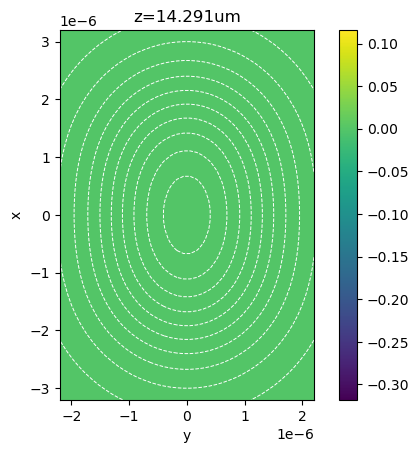

In [29]:
# Generate spatial grid
x = np.linspace(*extend[0], n_pot_steps[0])
y = np.linspace(*extend[1], n_pot_steps[1])
z = np.linspace(*extend[2], n_pot_steps[2])

x3D, y3D, z3D = np.meshgrid(x, y, z,indexing="ij")  # Ensure correct indexing

# Compute potential (Replace with actual function)
pot = potential(x3D, y3D, z3D)

state_number = 3

# Create figure and axis
fig, ax = plt.subplots()
im = ax.imshow(states[state_number, :, :, 0], extent=[*extend[1], *extend[0]], origin="lower",
               vmin=np.min(states[state_number]), vmax=np.max(states[state_number]))

plt.xlabel("y")
plt.ylabel("x")
plt.colorbar(im)

# Initialize contour as None before defining it globally
contour = None

# Animation update function
def update(frame):
    global contour  # Ensure we're modifying the global variable

    im.set_data(states[state_number, :, :, frame])  # Update image data
    ax.set_title(f"z={z[frame]/si.um:.3f}um")  # Update title

    # Remove old contours if they exist
    if contour is not None:
        for c in contour.collections:
            c.remove()

    # Redraw contour plot
    contour = ax.contour(pot[:, :, frame], levels=10, colors='white', linewidths=0.7, extent=[*extend[1], *extend[0]])

# Create the first contour plot after defining update()
contour = ax.contour(pot[:, :, 0], levels=10, colors='white', linewidths=0.7, extent=[*extend[1], *extend[0]])

# Create animation
frames = n_pot_steps[2]  # Number of slices
ani = animation.FuncAnimation(fig, update, frames=frames, interval=100)

ani.save(f"animations/state{state_number}.gif", writer="pillow", fps=10)  # Save as GIF

plt.show()


In [ ]:
trap.get_total_intensity(with_2dtrap=False)

2*P_t1*exp((-2*y**2 - 2*(d_t/2 + x)**2)/(W_t1**2*(1 + lambda**2*z**2/(pi**2*W_t1**4))))/(pi*W_t1**2*(1 + lambda**2*z**2/(pi**2*W_t1**4))) + 2*P_t2*exp((-2*y**2 - 2*(-d_t/2 + x)**2)/(W_t2**2*(1 + lambda**2*z**2/(pi**2*W_t2**4))))/(pi*W_t2**2*(1 + lambda**2*z**2/(pi**2*W_t2**4)))

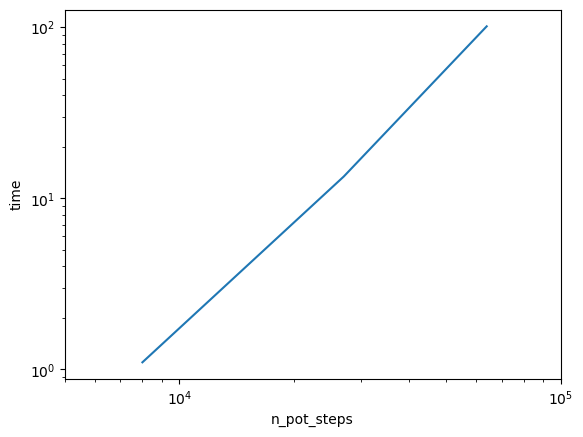

In [ ]:
plt.loglog(np.array([20**3,30**3,40**3]),np.array([1.1,13.4,101]))
plt.xlim(5*10**3,10**5)
plt.xlabel("n_pot_steps")
plt.ylabel("time")
plt.show()

## This is quite expensive. Let's try individual components.

## Make animations with this script:

C:\Users\naeve\AppData\Local\Temp\ipykernel_17932\735623296.py:42: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  for c in contour.collections:


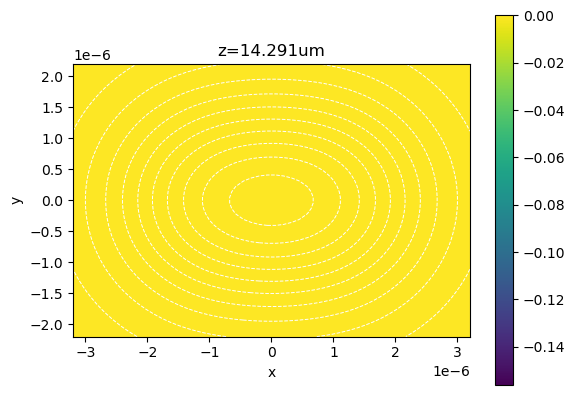

In [ ]:
import numpy as np

data = np.load("test_3D_50_50_50.npz")

for key in data.keys():
    globals()[key] = data[key]

x3D, y3D, z3D = np.meshgrid(x, y, z)  # Ensure correct indexing

extend = [(x.min(),x.max()),
          (y.min(),y.max()),
          (z.min(),z.max())]

n_pot_steps = [len(x),len(y),len(z)]

state_number = 0

# Create figure and axis
fig, ax = plt.subplots()
im = ax.imshow(states[state_number, :, :, 0], extent=[*extend[0], *extend[1]], origin="lower",
               vmin=np.min(states[state_number]), vmax=np.max(states[state_number]))

plt.xlabel("x")
plt.ylabel("y")
plt.colorbar(im)

# Initialize contour as None before defining it globally
contour = None

# Animation update function
def update(frame):
    global contour  # Ensure we're modifying the global variable

    im.set_data(states[state_number, :, :, frame])  # Update image data
    ax.set_title(f"z={z[frame]/si.um:.3f}um")  # Update title

    # Remove old contours if they exist
    if contour is not None:
        for c in contour.collections:
            c.remove()

    # Redraw contour plot
    contour = ax.contour(pot[:, :, frame], levels=10, colors='white', linewidths=0.7, extent=[*extend[0], *extend[1]])

# Create the first contour plot after defining update()
contour = ax.contour(pot[:, :, 0], levels=10, colors='white', linewidths=0.7, extent=[*extend[0], *extend[1]])

# Create animation
frames = n_pot_steps[2]  # Number of slices
ani = animation.FuncAnimation(fig, update, frames=frames, interval=100)

ani.save(f"animations/state{state_number}.gif", writer="pillow", fps=10)  # Save as GIF

plt.show()
